In [1]:
import logging
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.algorithms.gcs_astar import GcsAstar
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.cost_estimators.factored_collision_free_ce import FactoredCollisionFreeCE

from large_gcs.contact.contact_regions_set import ContactRegionParams

import numpy as np
from copy import deepcopy
from IPython.display import HTML


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
logging.getLogger("large_gcs").setLevel(logging.DEBUG)
logging.getLogger("drake").setLevel(logging.WARNING)

In [2]:
base_name = "cg_trichal2"

In [3]:
cg = ContactGraph.load_from_file(ContactGraphGeneratorParams.graph_file_path_from_name(base_name))

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...


Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


100%|██████████| 3/3 [00:00<00:00, 59.65it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:00<00:00, 385.04it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 10824.86it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 11267.31it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6408/6408 [00:00<00:00, 8359.30it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6408/6408 [00:01<00:00, 5313.84it/s]
INFO:large_gcs.graph.graph:Adding 6408 edges to graph...
100%|██████████| 6408/6408 [00:01<00:00, 5054.47it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertices=181, n_edges=6408, source=[array([3.250, 0.000]), array([1.500, 0.500])], target

In [4]:
cg_inc = IncrementalContactGraph.load_from_file(ContactGraphGeneratorParams.inc_graph_file_path_from_name(base_name))

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 38304.15it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 8322.03it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 56.07it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 4508.99it/s]


In [5]:
cg_inc._modes_w_possible_edge_to_target

{'IC|obs0_f2-obj0_f1',
 'NC|obj0_f3-rob0_v0',
 'NC|obs0_f2-obj0_f1',
 'NC|obs0_f2-rob0_v0'}

In [6]:
cg.incoming_edges("target")

[Edge(u="('IC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')", v='target', costs=[<pydrake.solvers.LinearCost object at 0x7f54e4b880b0>], constraints=[<pydrake.solvers.LinearEqualityConstraint object at 0x7f54e4a6ec70>], gcs_edge=<pydrake.geometry.optimization.GraphOfConvexSets.Edge object at 0x7f54e48e4070>),
 Edge(u="('NC|obs0_f2-obj0_f1', 'NC|obs0_f2-rob0_v0', 'NC|obj0_f3-rob0_v0')", v='target', costs=[<pydrake.solvers.LinearCost object at 0x7f54e4a950f0>], constraints=[<pydrake.solvers.LinearEqualityConstraint object at 0x7f54e49fbd70>], gcs_edge=<pydrake.geometry.optimization.GraphOfConvexSets.Edge object at 0x7f54e47fbdb0>)]

In [7]:
cg_inc.outgoing_edges("source")

[Edge(u='source', v="('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", costs=[<pydrake.solvers.LinearCost object at 0x7f54e4c0eeb0>], constraints=[<pydrake.solvers.LinearEqualityConstraint object at 0x7f54e4c0ea30>], gcs_edge=None)]

In [8]:
cg.outgoing_edges("source")

[Edge(u='source', v="('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')", costs=[<pydrake.solvers.LinearCost object at 0x7f54e4aa0930>], constraints=[<pydrake.solvers.LinearEqualityConstraint object at 0x7f54e4a06cb0>], gcs_edge=<pydrake.geometry.optimization.GraphOfConvexSets.Edge object at 0x7f54e4813eb0>)]

In [9]:
cost_estimator_se = ShortcutEdgeCE(cg, contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar_se = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator_se,
    reexplore_level=ReexploreLevel.NONE,
)
sol_se = gcs_astar_se.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'target', 'source'}
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.011, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 1 neighbors (0)
DEBUG:large_gcs.algorithms.gcs_astar_convex_restriction:edge source -> ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0') is feasible, new dist: 238.26001654659783, added to pq True
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {"('NC|obs0_f0-obj0_v3', 'NC|obs0_

In [10]:
cost_estimator = FactoredCollisionFreeCE(cg, use_combined_gcs=True, obj_multiplier=100)

gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.cost_estimators.factored_collision_free_ce:creating 2 collision free graphs...
0it [00:00, ?it/s]INFO:large_gcs.graph.factored_collision_free_graph:Creating vertex costs for factored_collision_free_graph...
100%|██████████| 6/6 [00:00<00:00, 7135.19it/s]
INFO:large_gcs.graph.graph:Adding 6 vertices to graph...
100%|██████████| 6/6 [00:00<00:00, 12300.01it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 15/15 [00:00<00:00, 6741.09it/s]
INFO:large_gcs.graph.contact_graph:24 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 24/24 [00:00<00:00, 11627.97it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 24/24 [00:00<00:00, 6603.04it/s]
INFO:large_gcs.graph.graph:Adding 24 edges to graph...
100%|██████████| 24/24 [00:00<00:00, 9606.19it/s]
INFO:large_gcs.graph.factored_collision_free_graph:Created factored collision free graph for obj0: GraphParams(dim_bounds=(2, 4

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkm1kcb6c/temp.m4v


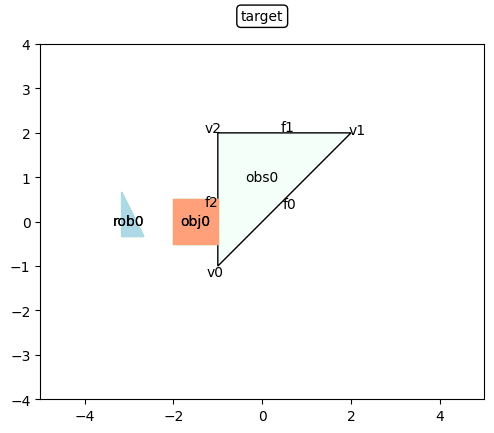

In [11]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

In [12]:
cost_estimator_se = ShortcutEdgeCE(cg_inc, contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar_se = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator_se,
    reexplore_level=ReexploreLevel.NONE,
)
sol_se = gcs_astar_se.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'target', 'source'}
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.667, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 1 neighbors (0)
DEBUG:large_gcs.algorithms.gcs_astar_convex_restriction:edge source -> ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0') is feasible, new dist: 238.26001654659783, added to pq True
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {"('NC|obs0_f0-obj0_v3', 'NC|obs0_

In [13]:
cost_estimator = FactoredCollisionFreeCE(cg_inc, use_combined_gcs=True, obj_multiplier=100)

gcs_astar = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.cost_estimators.factored_collision_free_ce:creating 2 collision free graphs...
0it [00:00, ?it/s]INFO:large_gcs.graph.factored_collision_free_graph:Creating vertex costs for factored_collision_free_graph...
100%|██████████| 6/6 [00:00<00:00, 9078.58it/s]
INFO:large_gcs.graph.graph:Adding 6 vertices to graph...
100%|██████████| 6/6 [00:00<00:00, 12998.88it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 15/15 [00:00<00:00, 11395.50it/s]
INFO:large_gcs.graph.contact_graph:24 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 24/24 [00:00<00:00, 10827.50it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 24/24 [00:00<00:00, 5988.65it/s]
INFO:large_gcs.graph.graph:Adding 24 edges to graph...
100%|██████████| 24/24 [00:00<00:00, 5887.43it/s]
INFO:large_gcs.graph.factored_collision_free_graph:Created factored collision free graph for obj0: GraphParams(dim_bounds=(2, 

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp6vfp4s6t/temp.m4v


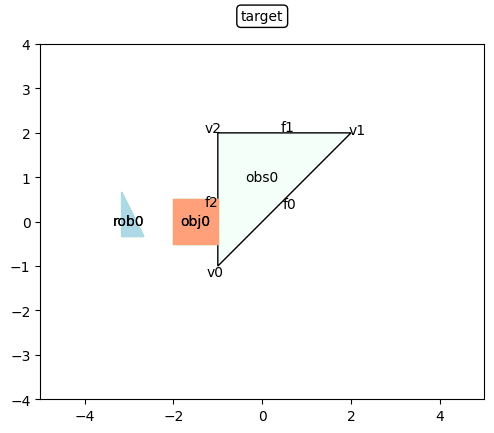

In [15]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())